In [1]:
from __future__ import division
import os
import os
import itertools
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import scipy
folder_directory =os.getcwd()
exec(open('../../../code/functions/python_libraries.py').read())

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/kristen/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/kristen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data

In [2]:
mac_x_id = pd.read_csv('./mac_to_id.csv',dtype={'mac': object})
mac_x_id = mac_x_id.loc[~mac_x_id.mac_clean.isnull()] ## we remove those without mac addresses (id's 104, 105)
print len(mac_x_id)
bt_nw = pd.read_csv('./bluetooth_nw.csv')
grad_y = pd.read_csv('./my_affil.csv') ## however, id=105 has survey data

104


#### subset to units we have survey data

In [3]:
## really should be 93 -- but to get 94, we'll keep id=105 since we have survey data, 
## but note that id=105 will not be a node in the network because we don't have unit's mac address
ids_subset = np.unique(mac_x_id.id)
print ids_subset
print ''
ids_survey_complete = np.unique(grad_y.id[~grad_y.affil_clean.isnull()])
print ids_survey_complete
print ''
print len(ids_subset[np.in1d(ids_subset, ids_survey_complete)])
print len(ids_survey_complete[np.in1d(ids_survey_complete, ids_subset)])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  35  36  37  39  40  41
  42  43  45  47  48  49  51  52  53  54  55  56  57  59  60  61  62  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 105]

93
93


In [4]:
## so instead -- we use this set of IDs.
mac_x_id = pd.read_csv('./mac_to_id.csv',dtype={'mac': object})
ids_subset = np.unique(mac_x_id.id)
ids_survey_complete = np.unique(grad_y.id[~grad_y.affil_clean.isnull()])
print len(ids_subset[np.in1d(ids_subset, ids_survey_complete)])
print len(ids_survey_complete[np.in1d(ids_survey_complete, ids_subset)])

94
94


In [5]:
mac_x_id = mac_x_id.loc[np.in1d(mac_x_id.id, ids_survey_complete)]
len(mac_x_id)

94

In [6]:
grad_y = grad_y[~grad_y.affil_clean.isnull()]

In [7]:
bt_nw.head()

,from_mac,time,to_mac
0,1,732338.706736,6.196498e+10
1,1,732338.706736,5.830200e+10
2,1,732338.710880,5.830200e+10
3,1,732338.710880,4.545268e+10
4,1,732338.710880,6.197357e+11


In [8]:
bt_nw = bt_nw.loc[np.in1d(bt_nw.from_mac, mac_x_id.id)]
bt_nw = bt_nw.loc[np.in1d(bt_nw.to_mac, mac_x_id.mac_clean)]
print len(bt_nw)

734625


In [9]:
mac_x_id.head()

,id,mac,mac_clean
2,2,[[6.19610249e+10]],6.196102e+10
3,3,[[6.19610249e+10]],6.196102e+10
4,4,[[6.19610249e+10]],6.196102e+10
5,5,[[6.1961025e+10]],6.196102e+10
6,6,[[6.19610249e+10]],6.196102e+10


In [10]:
grad_y.head()

,affil,id,affil_clean
2,"[[array([u'1styeargrad '], dtype='<U12')]]",2,1styeargrad
3,"[[array([u'mlgrad'], dtype='<U6')]]",3,mlgrad
4,"[[array([u'mlgrad'], dtype='<U6')]]",4,mlgrad
5,"[[array([u'mlgrad'], dtype='<U6')]]",5,mlgrad
6,"[[array([u'grad'], dtype='<U4')]]",6,grad


In [11]:
grad_y.affil_clean[3]

'mlgrad'

In [12]:
bt_nw.columns = ['from_mac_id','time','to_mac']
bt_nw.head()

,from_mac_id,time,to_mac
398,2,731947.842546,6.196494e+10
401,2,731947.881007,6.196102e+10
402,2,731947.885266,6.196095e+10
403,2,731947.888009,6.196102e+10
404,2,731947.889641,6.196102e+10


In [13]:
print np.sum(bt_nw.from_mac_id.isnull())
print np.sum(bt_nw.to_mac.isnull())
print len(np.unique(bt_nw.from_mac_id))

0
0
88


In [14]:
## merge in from_mac
bt_nw = bt_nw.merge(mac_x_id[['id','mac_clean']],
           left_on = 'from_mac_id',
           right_on = 'id',
           how = 'left')

bt_nw.drop('id', axis = 1, inplace = True)

In [15]:
bt_nw.head()

,from_mac_id,time,to_mac,mac_clean
0,2,731947.842546,6.196494e+10,6.196102e+10
1,2,731947.881007,6.196102e+10,6.196102e+10
2,2,731947.885266,6.196095e+10,6.196102e+10
3,2,731947.888009,6.196102e+10,6.196102e+10
4,2,731947.889641,6.196102e+10,6.196102e+10


#### making note id=105 is odd -- because it'll have out-degree, but no in-degree because we can't merge in based on mac-address

In [16]:
print np.sum(bt_nw.mac_clean.isnull())
print np.sum(bt_nw.from_mac_id==105)
print np.sum(bt_nw.from_mac_id.isnull())
print np.unique(bt_nw.from_mac_id)

1695
1695
0
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  35  36  37  39  40  41
  43  45  48  49  51  52  53  54  55  56  57  59  60  61  62  64  66  67
  68  69  70  72  73  74  75  76  77  78  80  81  82  83  84  85  86  87
  88  89  90  92  93  94  95  96  97  98  99 100 101 102 103 105]


In [17]:
bt_nw.rename(columns={"mac_clean": "from_mac"}, inplace = True)
bt_nw.head()

,from_mac_id,time,to_mac,from_mac
0,2,731947.842546,6.196494e+10,6.196102e+10
1,2,731947.881007,6.196102e+10,6.196102e+10
2,2,731947.885266,6.196095e+10,6.196102e+10
3,2,731947.888009,6.196102e+10,6.196102e+10
4,2,731947.889641,6.196102e+10,6.196102e+10


In [18]:
bt_nw = bt_nw.merge(mac_x_id[['id','mac_clean']],
           left_on = 'to_mac',
           right_on = 'mac_clean',
           how = 'left')
bt_nw.head()


,from_mac_id,time,to_mac,from_mac,id,mac_clean
0,2,731947.842546,6.196494e+10,6.196102e+10,62,6.196494e+10
1,2,731947.881007,6.196102e+10,6.196102e+10,3,6.196102e+10
2,2,731947.885266,6.196095e+10,6.196102e+10,28,6.196095e+10
3,2,731947.888009,6.196102e+10,6.196102e+10,18,6.196102e+10
4,2,731947.889641,6.196102e+10,6.196102e+10,18,6.196102e+10


In [19]:
bt_nw.drop('mac_clean', axis = 1, inplace = True)
bt_nw.head()

,from_mac_id,time,to_mac,from_mac,id
0,2,731947.842546,6.196494e+10,6.196102e+10,62
1,2,731947.881007,6.196102e+10,6.196102e+10,3
2,2,731947.885266,6.196095e+10,6.196102e+10,28
3,2,731947.888009,6.196102e+10,6.196102e+10,18
4,2,731947.889641,6.196102e+10,6.196102e+10,18


In [20]:
bt_nw.rename(columns={"id": "to_mac_id"}, inplace = True)
bt_nw.head()

,from_mac_id,time,to_mac,from_mac,to_mac_id
0,2,731947.842546,6.196494e+10,6.196102e+10,62
1,2,731947.881007,6.196102e+10,6.196102e+10,3
2,2,731947.885266,6.196095e+10,6.196102e+10,28
3,2,731947.888009,6.196102e+10,6.196102e+10,18
4,2,731947.889641,6.196102e+10,6.196102e+10,18


In [21]:
print len(np.unique(bt_nw.from_mac))
print len(np.unique(bt_nw.from_mac_id))
print len(np.unique(bt_nw.to_mac_id))
print np.sum(bt_nw.from_mac_id.isnull())
print np.sum(bt_nw.to_mac_id.isnull())

## how many unique ids are ever in a nw?
print len(np.unique(np.concatenate((np.unique(bt_nw.from_mac_id), np.unique(bt_nw.to_mac_id)))))
print np.unique(np.concatenate((np.unique(bt_nw.from_mac_id), np.unique(bt_nw.to_mac_id))))

1782
88
91
0
0
93
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  35  36  37  39  40  41
  42  43  45  47  48  49  51  52  53  54  55  56  57  59  60  61  62  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 105]


### finally, check we only have individuals in study

In [22]:
print np.sum(bt_nw.from_mac.isnull())
print np.sum(bt_nw.from_mac_id==105)

1695
1695


In [23]:
print np.sum(bt_nw.to_mac.isnull())

0


## Convert time and get baseline counts of grad students in each month train/test

In [24]:
bt_nw.head()

,from_mac_id,time,to_mac,from_mac,to_mac_id
0,2,731947.842546,6.196494e+10,6.196102e+10,62
1,2,731947.881007,6.196102e+10,6.196102e+10,3
2,2,731947.885266,6.196095e+10,6.196102e+10,28
3,2,731947.888009,6.196102e+10,6.196102e+10,18
4,2,731947.889641,6.196102e+10,6.196102e+10,18


In [25]:
bt_nw.time[0]
print np.min(bt_nw.time)
print np.max(bt_nw.time)



731947.1689467594
732507.737025463


In [26]:
from datetime import datetime, timedelta

## https://jeremykun.com/2014/01/21/realitymining-a-case-study-in-the-woes-of-data-processing/
def convertDatetime(dt):
    return datetime.fromordinal(int(dt)) + timedelta(days=dt%1) - timedelta(days=366) - timedelta(hours=5)


In [27]:
j = 2
print convertDatetime(bt_nw.time[j])
print convertDatetime(bt_nw.time[j]).month
#print convertDatetime(bt_nw.time[j]).day
print convertDatetime(bt_nw.time[j]).year

2004-01-01 16:14:47.000007
1
2004


In [28]:
tmp = map(convertDatetime, bt_nw.time)

In [29]:
month = []
year = []
for j in range(len(tmp)):
    month.append(tmp[j].month)
    year.append(tmp[j].year)

In [30]:
bt_nw['month'] = month
bt_nw['year'] = year
bt_nw.head()

,from_mac_id,time,to_mac,from_mac,to_mac_id,month,year
0,2,731947.842546,6.196494e+10,6.196102e+10,62,1,2004
1,2,731947.881007,6.196102e+10,6.196102e+10,3,1,2004
2,2,731947.885266,6.196095e+10,6.196102e+10,28,1,2004
3,2,731947.888009,6.196102e+10,6.196102e+10,18,1,2004
4,2,731947.889641,6.196102e+10,6.196102e+10,18,1,2004


In [31]:
bt_nw.tail()

,from_mac_id,time,to_mac,from_mac,to_mac_id,month,year
734620,105,732366.667558,6.196498e+10,NaN,52,2,2005
734621,105,732366.678843,6.196498e+10,NaN,52,2,2005
734622,105,732366.682465,6.196498e+10,NaN,52,2,2005
734623,105,732366.719618,6.196494e+10,NaN,62,2,2005
734624,105,732366.734236,6.196494e+10,NaN,62,2,2005


In [32]:
bt_nw.head()

,from_mac_id,time,to_mac,from_mac,to_mac_id,month,year
0,2,731947.842546,6.196494e+10,6.196102e+10,62,1,2004
1,2,731947.881007,6.196102e+10,6.196102e+10,3,1,2004
2,2,731947.885266,6.196095e+10,6.196102e+10,28,1,2004
3,2,731947.888009,6.196102e+10,6.196102e+10,18,1,2004
4,2,731947.889641,6.196102e+10,6.196102e+10,18,1,2004


#### make undirected

In [33]:
#bt_nw_undirected = bt_nw.copy()
#bt_nw_undirected.from_mac_id = bt_nw.to_mac_id
#bt_nw_undirected.to_mac_id = bt_nw.from_mac_id



In [34]:
#bt_nw = bt_nw.append(bt_nw_undirected)

In [35]:
#bt_nw.drop_duplicates(inplace = True)

## Merge in class attribute for from_mac_id

In [83]:
bt_nw_y = bt_nw.merge(grad_y[['id','affil_clean']],
                     left_on = 'from_mac_id',
                     right_on = 'id',
                     how = 'left')

In [84]:
bt_nw_y.head()

,from_mac_id,time,to_mac,from_mac,to_mac_id,month,year,id,affil_clean
0,2,731947.842546,6.196494e+10,6.196102e+10,62,1,2004,2,1styeargrad
1,2,731947.881007,6.196102e+10,6.196102e+10,3,1,2004,2,1styeargrad
2,2,731947.885266,6.196095e+10,6.196102e+10,28,1,2004,2,1styeargrad
3,2,731947.888009,6.196102e+10,6.196102e+10,18,1,2004,2,1styeargrad
4,2,731947.889641,6.196102e+10,6.196102e+10,18,1,2004,2,1styeargrad


In [146]:
print np.unique(bt_nw_y.affil_clean)
print np.sum(bt_nw_y.affil_clean.isnull())

## readme
#The subject’s affiliation:
#'mlgrad’ – Media Lab Graduate Student (not a first year)
#'1styeargrad’ – Media Lab First Year Graduate Student
#'mlfrosh’ – Media Lab First Year Undergraduate Student
#‘mlstaff’ – Media Lab Staff
#‘mlurop’ – Media Lab Undergraduate
#‘professor’ – Media Lab Professor


## from RolX paper: http://www.eliassi.org/papers/henderson-kdd2012.pdf
#"The first set of experiments involves a binary classification task where we
#try to predict whether a given subject is a business school
#student or not. The second set is similar, where we try
#to predict whether a subject is a graduate student in the
#Media Lab or not."

#print np.mean(bt_nw_y.affil_clean=='mlgrad')
#bt_nw_y['y'] = (bt_nw_y.affil_clean=='mlgrad')+0
bt_nw_y['y'] = ((bt_nw_y.affil_clean=='mlgrad') | (bt_nw_y.affil_clean=='1styeargrad '))+0
print np.unique(bt_nw_y.y)
print np.sum(grad_y.affil_clean=='grad')

['1styeargrad ' 'grad' 'mlfrosh' 'mlgrad' 'mlstaff' 'mlurop' 'professor'
 'sloan' 'sloan_2']
0
[0 1]
3


In [86]:
print bt_nw_y[['month','year']].drop_duplicates()

        month  year
0           1  2004
656         8  2004
1972        9  2004
3648       11  2004
6632       12  2004
15640       1  2005
16222       7  2004
64805      10  2004
76319       2  2005
78021       3  2005
82906       4  2005
88475       5  2005
265648      6  2005
468495      7  2005
468807      3  2004
704756     12  2003


In [87]:
bt_nw_y.head()

,from_mac_id,time,to_mac,from_mac,to_mac_id,month,year,id,affil_clean,y
0,2,731947.842546,6.196494e+10,6.196102e+10,62,1,2004,2,1styeargrad,1
1,2,731947.881007,6.196102e+10,6.196102e+10,3,1,2004,2,1styeargrad,1
2,2,731947.885266,6.196095e+10,6.196102e+10,28,1,2004,2,1styeargrad,1
3,2,731947.888009,6.196102e+10,6.196102e+10,18,1,2004,2,1styeargrad,1
4,2,731947.889641,6.196102e+10,6.196102e+10,18,1,2004,2,1styeargrad,1


## Baseline Classifier
"The Baseline is a classifier that
learns to always predict the majority class of the training set
on the test set."

In [88]:
month_yr_train_test = bt_nw_y[['month','year']].drop_duplicates().sort_values(['year','month'])[3:15]
month_yr_train_test

,month,year
16222,7,2004
656,8,2004
1972,9,2004
64805,10,2004
3648,11,2004
6632,12,2004
15640,1,2005
76319,2,2005
78021,3,2005
82906,4,2005


In [90]:
from sklearn.metrics import f1_score

In [133]:
print np.unique(bt_nw_y.affil_clean)
print np.sum(grad_y.affil_clean=='sloan')
print np.sum(grad_y.affil_clean=='sloan_2')

['1styeargrad ' 'grad' 'mlfrosh' 'mlgrad' 'mlstaff' 'mlurop' 'professor'
 'sloan' 'sloan_2']
26
1


In [151]:
acc_macro = []
acc_micro = []
acc_wtd = []
acc_generic = []
for j in range(len(month_yr_train_test)-1):
    m_train = month_yr_train_test.iloc[j]['month']
    yr_train = month_yr_train_test.iloc[j]['year']


    m_test = month_yr_train_test.iloc[j+1]['month']
    yr_test = month_yr_train_test.iloc[j+1]['year']
    
    
    bt_nw_y_train = bt_nw_y[(bt_nw_y.month==m_train) & (bt_nw_y.year==yr_train)]
    bt_nw_y_test = bt_nw_y[(bt_nw_y.month==m_test) & (bt_nw_y.year==yr_test)]

    ## get unique node id's if node is from- or to- in training month
    gender_train = pd.DataFrame({'id':np.unique(np.concatenate((bt_nw_y_train.from_mac_id, bt_nw_y_train.to_mac_id)))})
    gender_train = gender_train.merge(grad_y[['id','affil_clean']],
                      on='id',
                      how = 'left')
    #gender_train['y'] = (gender_train.affil_clean=='mlgrad')+0
    #gender_train['y'] = ((gender_train.affil_clean=='mlgrad') | (gender_train.affil_clean=='1styeargrad '))+0
    #gender_train['y'] = (gender_train.affil_clean=='1styeargrad ')+0
    gender_train['y'] = ((gender_train.affil_clean=='mlgrad') | 
                         (gender_train.affil_clean=='1styeargrad ') | 
                         (gender_train.affil_clean=='grad '))+0
    
    
    
    ## business
    #gender_train['y'] = ((gender_train.affil_clean=='sloan') | (gender_train.affil_clean=='sloan_2'))+0
    
    ## get unique node id's if node is from- or to- in testing month
    gender_test = pd.DataFrame({'id':np.unique(np.concatenate((bt_nw_y_test.from_mac_id, bt_nw_y_test.to_mac_id)))})
    gender_test = gender_test.merge(grad_y[['id','affil_clean']],
                      on='id',
                      how = 'left')
    #gender_test['y'] = (gender_test.affil_clean=='mlgrad')+0
    #gender_test['y'] = ((gender_test.affil_clean=='mlgrad') | (gender_test.affil_clean=='1styeargrad '))+0
    #gender_test['y'] = (gender_test.affil_clean=='1styeargrad ')+0
    gender_test['y'] = ((gender_test.affil_clean=='mlgrad') | 
                        (gender_test.affil_clean=='1styeargrad ') |
                       (gender_test.affil_clean== 'grad'))+0
    
    ## business
    #gender_test['y'] = ((gender_test.affil_clean=='sloan') | (gender_test.affil_clean=='sloan_2'))+0

    # get majority label in training data
    num1 = np.sum(gender_train.y==1)
    num0 = np.sum(gender_train.y==0)
    
    ## sanity check
    print 'train-month/year: ', m_train, ' ', yr_train
    print 'proportion train-grad-student', np.mean(gender_train.y==1)
    print 'num nodes (train): ', len(np.unique(gender_train.id))
    print 'test-month/year: ', m_test, ' ', yr_test
    print 'proportion test-grad-student', np.mean(gender_test.y==1)
    print 'num nodes (test): ', len(np.unique(gender_test.id))


    print ''

    if num1 > num0:
        label = 1
    else:
        label = 0
        
    y_predict = np.repeat(label,len(gender_test))
    y_true = np.array(gender_test.y)
    
    acc_generic.append(np.mean(y_true == y_predict))
    acc_macro.append(f1_score(y_true, y_predict, average='macro')  )
    acc_micro.append( f1_score(y_true, y_predict, average='micro')  )
    acc_wtd.append( f1_score(y_true, y_predict, average='weighted')  )


train-month/year:  7   2004
proportion train-grad-student 0.4
num nodes (train):  30
test-month/year:  8   2004
proportion test-grad-student 0.5333333333333333
num nodes (test):  45

train-month/year:  8   2004
proportion train-grad-student 0.4666666666666667
num nodes (train):  45
test-month/year:  9   2004
proportion test-grad-student 0.5617977528089888
num nodes (test):  89

train-month/year:  9   2004
proportion train-grad-student 0.5393258426966292
num nodes (train):  89
test-month/year:  10   2004
proportion test-grad-student 0.573170731707317
num nodes (test):  82

train-month/year:  10   2004
proportion train-grad-student 0.5365853658536586
num nodes (train):  82
test-month/year:  11   2004
proportion test-grad-student 0.550561797752809
num nodes (test):  89

train-month/year:  11   2004
proportion train-grad-student 0.5280898876404494
num nodes (train):  89
test-month/year:  12   2004
proportion test-grad-student 0.5444444444444444
num nodes (test):  90

train-month/year:  12 

In [152]:
print np.array(acc_generic)!=np.array(acc_micro)
print acc_generic
print ''
print acc_micro

[False False False False False False False False False False False]
[0.4666666666666667, 0.43820224719101125, 0.573170731707317, 0.550561797752809, 0.5444444444444444, 0.5681818181818182, 0.5679012345679012, 0.5822784810126582, 0.5753424657534246, 0.5555555555555556, 0.7380952380952381]

[0.4666666666666667, 0.43820224719101125, 0.573170731707317, 0.550561797752809, 0.5444444444444444, 0.5681818181818182, 0.5679012345679012, 0.5822784810126582, 0.5753424657534246, 0.5555555555555556, 0.7380952380952381]


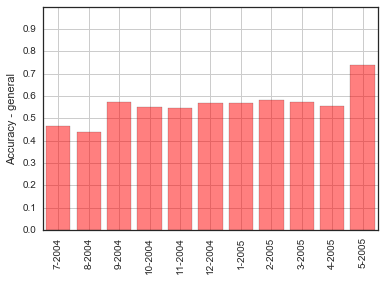

In [153]:
%matplotlib inline
plt.bar(range(len(acc_generic)),acc_generic, color = 'red', alpha = 0.5,align = 'center')
plt.ylabel('Accuracy - general')
plt.xticks(range(len(acc_generic)),
           np.array(month_yr_train_test.month.astype(str) +'-' + month_yr_train_test.year.astype(str) )[0:11],
          rotation = 90)
plt.xlim(-0.5,10.5)
plt.ylim(0,1)
plt.yticks(np.arange(0,1,0.1))
plt.grid(True, which = 'major')
plt.show()

### other accuracy metrics

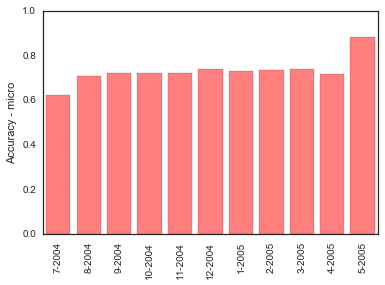

In [138]:
%matplotlib inline
plt.bar(range(len(acc_micro)),acc_micro, color = 'red', alpha = 0.5,align = 'center')
plt.xticks(range(len(acc_macro)),
           np.array(month_yr_train_test.month.astype(str) +'-' + month_yr_train_test.year.astype(str) )[0:11],
          rotation = 90)
plt.ylabel('Accuracy - micro')
plt.xlim(-0.5,10.5)
plt.ylim(0,1)
plt.show()

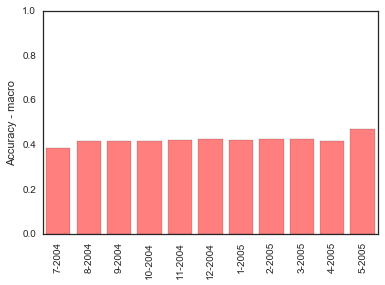

In [141]:
%matplotlib inline
plt.bar(range(len(acc_macro)),acc_macro, color = 'red', alpha = 0.5,align = 'center')
plt.ylabel('Accuracy - macro')
plt.xticks(range(len(acc_macro)),
           np.array(month_yr_train_test.month.astype(str) +'-' + month_yr_train_test.year.astype(str) )[0:11],
          rotation = 90)
plt.xlim(-0.5,10.5)
plt.ylim(0,1)
plt.show()

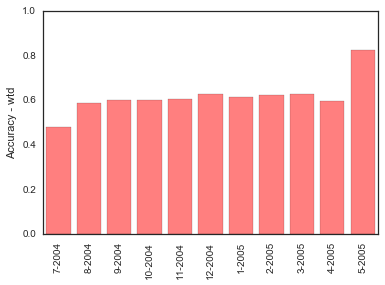

In [142]:
%matplotlib inline
plt.bar(range(len(acc_wtd)),acc_wtd, color = 'red', alpha = 0.5,align = 'center')
plt.xticks(range(len(acc_macro)),
           np.array(month_yr_train_test.month.astype(str) +'-' + month_yr_train_test.year.astype(str) )[0:11],
          rotation = 90)
plt.ylabel('Accuracy - wtd')
plt.xlim(-0.5,10.5)
plt.ylim(0,1)
plt.show()

In [143]:
bt_nw_y.head()

,from_mac_id,time,to_mac,from_mac,to_mac_id,month,year,id,affil_clean,y
0,2,731947.842546,6.196494e+10,6.196102e+10,62,1,2004,2,1styeargrad,1
1,2,731947.881007,6.196102e+10,6.196102e+10,3,1,2004,2,1styeargrad,1
2,2,731947.885266,6.196095e+10,6.196102e+10,28,1,2004,2,1styeargrad,1
3,2,731947.888009,6.196102e+10,6.196102e+10,18,1,2004,2,1styeargrad,1
4,2,731947.889641,6.196102e+10,6.196102e+10,18,1,2004,2,1styeargrad,1
